<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# TF-TRT Inference from Keras Model with TensorFlow 2.0


## Introduction
The NVIDIA TensorRT is a C++ library that facilitates high performance inference on NVIDIA graphics processing units (GPUs). TensorRT takes a trained network, which consists of a network definition and a set of trained parameters, and produces a highly optimized runtime engine which performs inference for that network.

TensorFlow™ integration with TensorRT™ (TF-TRT) optimizes and executes compatible subgraphs, allowing TensorFlow to execute the remaining graph. While you can still use TensorFlow's wide and flexible feature set, TensorRT will parse the model and apply optimizations to the portions of the graph wherever possible.

In this notebook, we demonstrate the process of creating a TF-TRT optimized model from a ResNet-50 Keras saved model.

## Requirement

### GPU

Before running this notebook, please set the Colab runtime environment to GPU via the menu *Runtime => Change runtime type => GPU*.

This demo will work on any NVIDIA GPU with CUDA cores, though for improved FP16 and INT8 inference, a Volta, Turing or newer generation GPU with Tensor cores is desired.  On Google Colab, this normally means a T4 GPU. If you are assigned an older K80 GPU, another trial at another time might give you a T4 GPU.


In [ ]:
!nvidia-smi

Tue May  3 04:32:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


## Upgrade cuda from 10.1 to cuda 11, install tensorrt7

In [ ]:
%%bash
wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
sudo add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/ /"
sudo apt-get update

Executing: /tmp/apt-key-gpghome.drvn7oOS3y/gpg.1.sh --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,733 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learn

--2021-02-21 23:14:13--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.20.126
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu1804.pin’

     0K                                                       100% 5.31M=0s

2021-02-21 23:14:13 (5.31 MB/s) - ‘cuda-ubuntu1804.pin’ saved [190/190]

gpg: requesting key from 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub'
gpg: key F60F4B3D7FA2AF80: "cudatools <cudatools@nvidia.com>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list.d/cuda.list:1
W: Target Packages (Packages) is

In [ ]:
%%bash
wget http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

--2021-02-21 23:14:22--  http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.20.126
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.20.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’

     0K ..                                                    100%  501M=0s

2021-02-21 23:14:23 (501 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’ saved [2926/2926]



In [ ]:
!ls

nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb  sample_data


In [ ]:
%%bash
sudo apt install ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
sudo apt-get update

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  nvidia-machine-learning-repo-ubuntu1804
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 2,926 B of archives.
After this operation, 37.9 kB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  nvidia-machine-learning-repo-ubuntu1804 1.0.0-1 [2,926 B]
Fetched 2,926 B in 0s (80.7 kB/s)
Selecting previously unselected package nvidia-machine-learning-repo-ubuntu1804.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/u



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list.d/cuda.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list.d/cuda.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list.d/cuda.list:1
W: Tar

In [ ]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/libnvinfer7_7.2.3-1+cuda11.1_amd64.deb
sudo apt install ./libnvinfer7_7.2.3-1+cuda11.1_amd64.deb
sudo apt-get update

Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  libnvinfer7
0 upgraded, 1 newly installed, 0 to remove and 51 not upgraded.
Need to get 131 MB of archives.
After this operation, 635 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  libnvinfer7 7.2.3-1+cuda11.1 [131 MB]
Fetched 131 MB in 2s (63.1 MB/s)
Selecting previously unselected package libnvinfer7.
(Reading database ... 155202 files and directories currently installed.)
Preparing to unpack .../libnvinfer7_7.2.3-1+cuda11.1_amd64.deb ...
Unpacking libnvinfer7 (7.2.3-1+cuda11.1) ...
Setting up libnvinfer7 (7.2.3-1+cuda11.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: 

--2022-05-03 04:39:18--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/libnvinfer7_7.2.3-1+cuda11.1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130738886 (125M) [application/x-deb]
Saving to: ‘libnvinfer7_7.2.3-1+cuda11.1_amd64.deb’

     0K .......... .......... .......... .......... ..........  0% 1.77M 70s
    50K .......... .......... .......... .......... ..........  0% 8.07M 43s
   100K .......... .......... .......... .......... ..........  0% 2.22M 47s
   150K .......... .......... .......... .......... ..........  0% 37.2M 36s
   200K .......... .......... .......... .......... ..........  0% 60.0M 29s
   250K .......... .......... .......... .......... ..........  0% 2.41M 33s
   300K .......... .......... .......... .

In [ ]:
%%bash
sudo apt-get install --no-install-recommends \
    cuda-11-0 \
    libcudnn8=8.0.4.30-1+cuda11.0  \
    libcudnn8-dev=8.0.4.30-1+cuda11.0

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-command-line-tools-11-0 cuda-compiler-11-0 cuda-cudart-dev-11-0
  cuda-cuobjdump-11-0 cuda-cupti-11-0 cuda-cupti-dev-11-0 cuda-demo-suite-11-0
  cuda-documentation-11-0 cuda-driver-dev-11-0 cuda-gdb-11-0
  cuda-libraries-11-0 cuda-libraries-dev-11-0 cuda-memcheck-11-0
  cuda-nsight-11-0 cuda-nsight-compute-11-0 cuda-nsight-systems-11-0
  cuda-nvcc-11-0 cuda-nvdisasm-11-0 cuda-nvml-dev-11-0 cuda-nvprof-11-0
  cuda-nvprune-11-0 cuda-nvrtc-11-0 cuda-nvrtc-dev-11-0 cuda-nvtx-11-0
  cuda-nvvp-11-0 cuda-runtime-11-0 cuda-samples-11-0 cuda-sanitizer-11-0
  cuda-toolkit-11-0 cuda-tools-11-0 cuda-visual-tools-11-0 libcublas-dev-11-0
  libcufft-11-0 libcufft-dev-11-0 libcurand-11-0 libcurand-dev-11-0
  libcusolver-11-0 libcusolver-dev-11-0 libcusparse-11-0 libcusparse-dev-11-0
  libnpp-11-0 libnpp-dev-11-0 libnvjpeg-11-0 libnvjpeg-dev-11-0
  nsight-systems

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 48.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list.d/cuda.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
%%bash
sudo apt-get install -y --no-install-recommends libnvinfer7=7.2.3-1+cuda11.1 \
    libnvinfer-dev=7.2.3-1+cuda11.1 \
    libnvinfer-plugin7=7.2.3-1+cuda11.1


Reading package lists...
Building dependency tree...
Reading state information...
libnvinfer7 is already the newest version (7.2.3-1+cuda11.1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  libnvinfer-dev libnvinfer-plugin7
0 upgraded, 2 newly installed, 0 to remove and 51 not upgraded.
Need to get 138 MB of archives.
After this operation, 816 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  libnvinfer-dev 7.2.3-1+cuda11.1 [132 MB]
Get:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  libnvinfer-plugin7 7.2.3-1+cuda11.1 [5,768 kB]
Fetched 138 MB in 2s (65.6 MB/s)
Selecting previously unselected package libnvinfer-dev.
(Reading database ... 155209 files and directories currently installed.)
Pre

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer-dev                         7.2.3-1+cuda11.1                    amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin7                     7.2.3-1+cuda11.1                    amd64        TensorRT plugin libraries
ii  libnvinfer7                            7.2.3-1+cuda11.1                    amd64        TensorRT runtime libraries


In [ ]:
import tensorflow as tf
print("Tensorflow version: ", tf.version.VERSION)

Tensorflow version:  2.8.0


In [ ]:
print("Tensorflow version: ", tf.version.VERSION)

Tensorflow version:  2.8.0


### Check Tensor core GPU
The below code check whether a Tensor-core GPU is present.

In [ ]:
!nvidia-smi

Tue May  3 04:46:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True

print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: None


P100 GPU does not support tensor core, V100 GPU support

### Importing required libraries

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


## Data
We download several random images for testing from the Internet.

In [ ]:
!rm -r ./data

rm: cannot remove './data': No such file or directory


In [ ]:
!mkdir ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://thumbs.dreamstime.com/t/speed-limit-traffic-sign-30-km-h-28093088.jpg"

--2022-05-11 22:14:53--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 65.9.84.113, 65.9.84.102, 65.9.84.77, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|65.9.84.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0s      

2022-05-11 22:14:53 (103 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2022-05-11 22:14:53--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 164.92.73.117
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|164.92.73.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452718 (442K) [image/jpeg]
Saving to: ‘./data/img1.JPG’

./

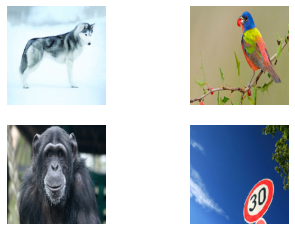

In [ ]:
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');

# Tensorflow 2.4.1

## Model

We next download and test a ResNet-50 pre-trained model from the Keras model zoo.

In [ ]:
model = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 1s 0us/step


49152/35363 [=========================================] - 0s 0us/step
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566213), ('n02109961', 'Eskimo_dog', 0.41737223), ('n02110063', 'malamute', 0.020951489)]
./data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.30138993), ('n01537544', 'indigo_bunting', 0.16979575), ('n01828970', 'bee_eater', 0.16134164)]
./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.5149854), ('n02480495', 'orangutan', 0.15896778), ('n02480855', 'gorilla', 0.15318137)]
./data/img3.JPG - Predicted: [('n06794110', 'street_sign', 0.20012435), ('n03355925', 'flagpole', 0.07479834), ('n03642806', 'laptop', 0.07448495)]


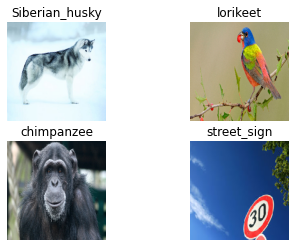

In [ ]:
for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');
  plt.title(decode_predictions(preds, top=3)[0][0][1])


In [ ]:
preds.shape

(1, 1000)

In [ ]:
result=decode_predictions(preds)
result

[[('n06794110', 'street_sign', 0.20012435),
  ('n03355925', 'flagpole', 0.07479834),
  ('n03642806', 'laptop', 0.07448495),
  ('n03888257', 'parachute', 0.061467964),
  ('n04228054', 'ski', 0.041682176)]]

TF-TRT takes input as aTensorFlow saved model, therefore, we re-export the Keras model as a TF saved model.

In [ ]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model')

INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [ ]:
!ls -al resnet50_saved_model

total 3280
drwxr-xr-x 4 root root    4096 May  3 04:47 .
drwxr-xr-x 1 root root    4096 May  3 04:47 ..
drwxr-xr-x 2 root root    4096 May  3 04:47 assets
-rw-r--r-- 1 root root  365902 May  3 04:47 keras_metadata.pb
-rw-r--r-- 1 root root 2973499 May  3 04:47 saved_model.pb
drwxr-xr-x 2 root root    4096 May  3 04:47 variables


In [ ]:
!saved_model_cli show --dir resnet50_saved_model --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['predictions'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1000)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
!saved_model_cli show --all --dir resnet50_saved_model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['predictions'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File

### Inference with native TF2.0 saved model

In [ ]:
# Benchmarking throughput
N_warmup_run = 50
N_run = 1000
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))



def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 122.3ms
Step 50: 90.9ms
Step 100: 67.3ms
Step 150: 68.0ms
Step 200: 77.6ms
Step 250: 65.3ms
Step 300: 68.8ms
Step 350: 67.1ms
Step 400: 72.5ms
Step 450: 66.6ms
Step 500: 64.2ms
Step 550: 65.5ms
Step 600: 80.1ms
Step 650: 64.6ms
Step 700: 62.5ms
Step 750: 64.9ms
Step 800: 64.4ms
Step 850: 63.4ms
Step 900: 63.6ms
Step 950: 63.8ms
Throughput: 116 images/s


### TF-TRT FP32 model

We first convert the TF native FP32 model to a TF-TRT FP32 model.

In [ ]:
pip install tensorflow-GPU==2.8.0

In [ ]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (7, 2, 2)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 3)
INFO:tensorflow:Loaded TensorRT 7.2.3 and linked TensorFlow against TensorRT 7.2.2. This is supported because TensorRT minor/patch upgrades are backward compatible.
INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets
Done Converting to TF-TRT FP32


Next, we load and test the TF-TRT FP32 model.

In [ ]:
def load_tftrtmodel(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)
    return infer

In [ ]:
def predict_tftrt(img_path, infer):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    #img_path = './data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)

    labeling = infer(x)
    preds = labeling['predictions'].numpy()
    #print('preds output: ', preds)
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    #plt.subplot(2,2,1)
    fig=plt.figure(figsize=(8, 8))
    plt.imshow(img);
    plt.axis('off');
    decodedresult=decode_predictions(preds, top=3)
    labelresult=decodedresult[0][0][1]
    print(labelresult)

    labelwithprob=str(labelresult)+", "+str(decodedresult[0][0][2])
    plt.title(labelwithprob)

In [ ]:
trtmodel_infer=load_tftrtmodel('resnet50_saved_model_TFTRT_FP32')

['serving_default']
{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566217), ('n02109961', 'Eskimo_dog', 0.41737172), ('n02110063', 'malamute', 0.02095156)]
Siberian_husky


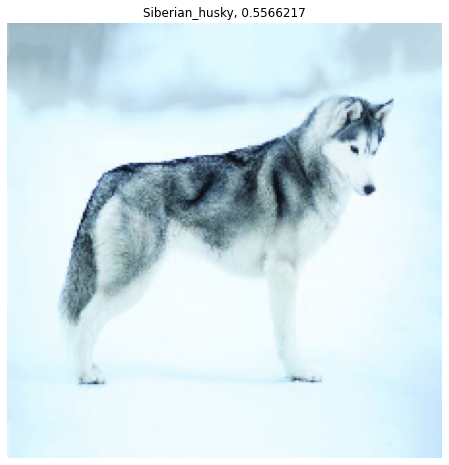

In [ ]:
predict_tftrt('./data/img0.JPG', trtmodel_infer)

In [ ]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [ ]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP32')

Step 0:  9.8ms
Step 50:  9.8ms
Step 100:  9.8ms
Step 150:  9.8ms
Step 200:  9.8ms
Step 250:  9.8ms
Step 300:  9.8ms
Step 350:  9.8ms
Step 400:  9.8ms
Step 450:  9.8ms
Step 500:  9.8ms
Step 550:  9.8ms
Step 600:  9.8ms
Step 650:  9.8ms
Step 700:  9.8ms
Step 750:  9.8ms
Step 800:  9.8ms
Step 850:  9.8ms
Step 900:  9.8ms
Step 950:  9.8ms
Throughput: 815 images/s


### TF-TRT FP16 model
We next convert the native TF FP32 saved model to TF-TRT FP16 model.

In [ ]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (7, 1, 3)
INFO:tensorflow:Loaded TensorRT version: (7, 1, 3)
INFO:tensorflow:Could not find TRTEngineOp_1_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets
Done Converting to TF-TRT FP16


In [ ]:
trtmodel_inferfp16=load_tftrtmodel('resnet50_saved_model_TFTRT_FP16')

['serving_default']
{'predictions': TensorSpec(shape=<unknown>, dtype=tf.float32, name='predictions')}


./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.5101183), ('n02480855', 'gorilla', 0.16051584), ('n02480495', 'orangutan', 0.15802728)]
chimpanzee


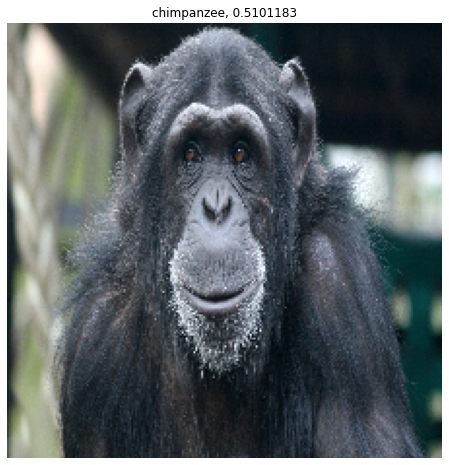

In [ ]:
predict_tftrt('./data/img2.JPG', trtmodel_inferfp16)

In [ ]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP16')

Step 0:  5.3ms
Step 50:  5.3ms
Step 100:  5.3ms
Step 150:  5.4ms
Step 200:  5.3ms
Step 250:  5.3ms
Step 300:  5.3ms
Step 350:  5.3ms
Step 400:  5.3ms
Step 450:  5.4ms
Step 500:  5.4ms
Step 550:  5.3ms
Step 600:  5.3ms
Step 650:  5.3ms
Step 700:  5.3ms
Step 750:  5.3ms
Step 800:  5.4ms
Step 850:  5.3ms
Step 900:  5.3ms
Step 950:  5.3ms
Throughput: 1505 images/s


### TF-TRT INT8 model

Creating TF-TRT INT8 model requires a small calibration dataset. This data set ideally should represent the test data in production well, and will be used to create a value histogram for each layer in the neural network for effective 8-bit quantization.  

Herein, for demonstration purposes, we take only the 4 images that we downloaded for calibration. In production, this set should be more representative of the production data.

Due to Colab memory limit which sometime causes TensorRT to crash, to proceed, first, restart the runtime by pressing CTRL+M or select *Runtime -> Restart runtime...* or simply execute the next cell.

In [ ]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './data/img%d.JPG' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


In [ ]:
print('Converting to TF-TRT INT8...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.INT8,
    max_workspace_size_bytes=8000000000,
    use_calibration=True)
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='resnet50_saved_model',
    conversion_params=conversion_params)

def calibration_input_fn():
    yield (batched_input, )
converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting to TF-TRT INT8...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_INT8/assets
Done Converting to TF-TRT INT8


In [ ]:
trtmodel_inferint8=load_tftrtmodel('resnet50_saved_model_TFTRT_INT8')

['serving_default']
{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


./data/img3.JPG - Predicted: [('n06794110', 'street_sign', 0.20012397), ('n03355925', 'flagpole', 0.07479812), ('n03642806', 'laptop', 0.074484766)]
street_sign


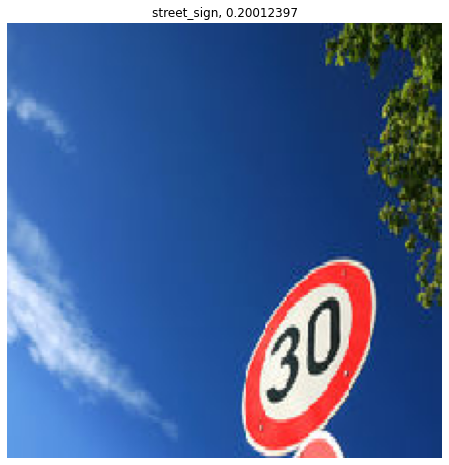

In [ ]:
predict_tftrt('./data/img3.JPG', trtmodel_inferint8)

In [ ]:
benchmark_tftrt('resnet50_saved_model_TFTRT_INT8')

Step 0: 17.8ms
Step 50: 17.6ms
Step 100: 17.7ms
Step 150: 17.7ms
Step 200: 17.7ms
Step 250: 17.7ms
Step 300: 17.7ms
Step 350: 17.7ms
Step 400: 17.7ms
Step 450: 17.7ms
Step 500: 17.7ms
Step 550: 17.7ms
Step 600: 17.7ms
Step 650: 17.7ms
Step 700: 17.7ms
Step 750: 17.7ms
Step 800: 17.7ms
Step 850: 17.7ms
Step 900: 17.7ms
Step 950: 17.7ms
Throughput: 452 images/s


## Conclusion
In this notebook, we have demonstrated the process of creating TF-TRT FP32, FP16 and INT8 inference models from an original Keras FP32 model, as well as verify their speed and accuracy.

### What's next
Try TF-TRT on your own model and data, and experience the simplicity and speed up it offers.